In [21]:
import netCDF4
from netCDF4 import Dataset

import csv
import pandas as pd

import numpy as np
from numpy import newaxis
# from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D

import math

import warnings
import dill
import timeit
from timeit import Timer

%matplotlib inline

## Extracting and organizing data arrays

In [22]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dataset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print(("\t\ttype:", repr(nc_fid.variables[key].dtype)))
            for ncattr in nc_fid.variables[key].ncattrs():
                print(('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr))))
        except KeyError:
            print(("\t\tWARNING: %s does not contain variable attributes" % key))

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim) 
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [23]:
def display_attr():
    """Displays attributes, dimensions, and variables for a WACCM netCDF4 dataset object."""
    nc_f = 'SABER_2009-01.nc'
    nc_fid = Dataset(nc_f, mode='r')

    nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)

# Uncomment next line for information on attr, dim, var info

#display_attr()

Dimensions: 

    Name: altitude
        size: 382

    Name: event
        size: 43726

event = a cycle of measurements from ~150 km down to ~ 10 km, aka for 382 altitude levels.  


Masked values with '--' as a placeholder can be dealt with using np.nan, but replacing it with 0 K as it's temperature value makes things simpler

In [24]:
nc_f = 'SABER_2009-01.nc'
ds = Dataset(nc_f, mode='r')

lat = ds.variables['tplatitude'][:] # dimensions: ('event', 'altitude')
lon = ds.variables['tplongitude'][:] # dimensions: ('event', 'altitude')
temp = ds.variables['ktemp'][:] # dimensions: ('event', 'altitude') # in K
alt = ds.variables['tpaltitude'][:] # dimensions: ('event', 'altitude')
date = ds.variables['date'][:] # dimensions: ('event',) # yyyyddd

ds.close()

### Latitude, longitude, and altitude values for the new temperature array

In [25]:
# make a new_attr_i to go with these arrays
new_lat = np.arange(-85, 85+10, 10)
new_lon = np.arange(10, 350+20, 20)
new_alt = np.arange(11, 149+2, 2)

### Functions for slicing/retrieving data from original arrays 
FIND_I = returns index for a single event and value
 - doesn't work well due to each event (exc alt variable) containing a small window of values

DATE_STARTI/ENDI = returns index corresponding to desired day

In [26]:
# doesn't work super well because each event array has such a small range**

def find_i(arr, event, desired_val):
    """Return the index corresponding to the array element closest to DESIRED_VAL for an EVENT."""
    event_arr = arr[event]
    closest_val = min(event_arr, key=lambda val: abs(desired_val - val))
    for i in range(len(event_arr)):
        if event_arr[i] == closest_val:
            return i
def lat_i(event, desired_val):
    return find_i(lat, event, desired_val)

def lon_i(event, desired_val):
    return find_i(lon, event, desired_val)

def temp_i(event, desired_val):
    return find_i(temp, event, desired_val)

def alt_i(event, desired_val):
    return find_i(alt, event, desired_val)

In [27]:
def date_starti(YYYYDDD):
    """Returns index for the first event at which a seven-digit date in the form YYYYDDD in the date array."""
    indices = np.where(date == YYYYDDD)
    first_i = indices[0][0]
    return first_i
def date_endi(YYYYDDD):
    """Return index + 1 for the last event at which a seven-digit date in the form YYYYDDD in the date array."""
    indices = np.where(date == YYYYDDD)
    last_i = indices[0][len(indices[0])-1]
    return last_i + 1

### Building the new array

Need a new temperature array with dimensions: ('altitude', 'longitude', 'latitude') for one day
i.e. new_array[0][1][2] returns a temperature (in K) for the 0th indexed altitude, 1st indexed longitude, and 2nd indexed latitude

Therefore, find all values that fit into a 10 degree latitude bin (e.g. 0 to 10 deg, 10 to 20), 20 degree longitude bin, and 2 degree altitude bin

--> BIN_I_WCOND returns a list of indices that fit into all 3 bins
    - can be thought of as a bins_for_lat function

--> BINS_FOR_LON replaces indices with temperatures (in K) and collects numpy arrays corresponding to every latitude 
    -for 10 deg sized bins, each array corresponds to 5, 10, ... 170, 175 deg
    
--> AVG_BINS_FOR_LON averages each latitude bin in a 2d array into one temperature value 

--> BINS_FOR_ALT collects lists corresponding to longitudes, where each list also contains lists corresponding to latitudes

--> BINS_FOR_DAY collects lists corresponding to altitudes, which contain lists corresponding to longitudes, which contain lists corresponding to latitudes, and returns a np.array

In [28]:
def bin_i_wcond(YYYYDDD, attr, lower, upper, attr2, lower2, upper2, attr3, lower3, upper3):
    """Return a list of indices for a flattened (1d) array of all measurements taken on YYYYDDD.
    Each list element corresponds to ATTR values between LOWER and UPPER, ATTR2 between LOWER2 and UPPER2, 
    and ATTR3 between LOWER3 and UPPER3.
    
    run to test:
    >>>bin_i_wcond(2009015, lat, 10, 20, lon, 0, 20, alt, 30, 32) 
    [5677, 5678, ..., 211581 #list of indices that correspond to bins centered at 5 deg lat, 10 deg lon, 1 km alt
    """
    
    # DATE_ATTRS_ is the flattened array discussed in the docstring for ATTR_
    date_attrs = attr[date_starti(YYYYDDD): date_endi(YYYYDDD)].flatten()
    date_attrs2 = attr2[date_starti(YYYYDDD): date_endi(YYYYDDD)].flatten()
    date_attrs3 = attr3[date_starti(YYYYDDD): date_endi(YYYYDDD)].flatten()
    
    # ATTR_STEP_ is the size of each ATTR_ bin
    attr_step = upper - lower
    attr_step2 = upper2 - lower2
    attr_step3 = upper3 - lower3
    
    # ATTR_INDICES_ are lists of indices that fit into the bin set by LOWER_, UPPER_, and their respective steps
    attr_indices =  np.where(abs(date_attrs - lower - (attr_step / 2)) <= attr_step / 2)[0] #lat
    attr_indices2 = np.where(abs(date_attrs2 - lower2 - (attr_step2 / 2)) <= attr_step2 / 2)[0] #lon
    attr_indices3 = np.where(abs(date_attrs3 - lower3 -(attr_step3 / 2)) <= attr_step3 / 2)[0] #alt
    
    # Collect only the elements that fall into each bin 
    indices_in_bin = []
    max_index = min(max(attr_indices, default=0), max(attr_indices2, default=0), max(attr_indices3, default=0))

    for i in range(max_index):
        if i in attr_indices and i in attr_indices2 and i in attr_indices3:
            indices_in_bin.append(i)
    return indices_in_bin

In [56]:
if __name__=='__main__':
    t = Timer(lambda: bin_i_wcond(2009015, lat, 10, 20, lon, 0, 20, alt, 30, 32))
    iters = 10
    print(t.timeit(number=iters) / iters)

3.3435954129001404


In [127]:
def bins_for_lon(YYYYDDD, lat_start, lat_stop, lat_step, lon_start, lon_stop, alt_start, alt_stop):
    """Return a 2d array of temperatures for all LAT_STEP degree bins of latitude for one 
    LON_START - LON_STOP degree bin of longitude by collecting temperature arrays corresponding to one latitude bin.
    
    >>>ZeroToTwentyLon = bins_for_lon(2009015, -90, 90, 10, 0, 20, 30, 35)
    
    >>>len(ZeroToTwentyLon)
    18 # ((lat_stop-lat_start)/lat_step) number of nested lists"""
    # Flatten YYYYDDD's temperature measurements so we can use BIN_I_WCOND
    date_temps = temp[date_starti(YYYYDDD): date_endi(YYYYDDD)].flatten()
    # Replace masked values with 0
    date_temps[date_temps.mask] = 0
    
    # Setting up latitude bins
    lat_stop = lat_stop + lat_step
    lat_edges = np.arange(lat_start, lat_stop, lat_step).tolist()
    
    # Appending latitude bins to build up a list corresponding to one longitude 
    bins_for_lon = []
    while len(lat_edges) >= 2:
        lower, upper = lat_edges[0], lat_edges[1]
        ind = bin_i_wcond(YYYYDDD, lat, lower, upper, lon, lon_start, lon_stop, alt, alt_start, alt_stop)
        bins_for_lon.append(date_temps[ind])
        lat_edges = lat_edges[1:]
    return bins_for_lon


#### BINS_FOR_LON runs linearly:
    - on my comp BIN_I_WCOND takes ~3 seconds, and BINS_FOR_LON takes ~50
    -3 s * 18 latitude bins --> ~54 s

In [34]:
if __name__=='__main__': # w max changed to min #16 s
    t = Timer(lambda: bins_for_lon(2009015, -90, 90, 10, 0, 20, 30, 35))
    iters = 10
    print(t.timeit(number=iters) / iters)

50.3289421292


In [128]:
def avg_bins_for_lon(YYYYDDD, lat_start, lat_stop, lat_step, lon_start, lon_stop, alt_start, alt_stop):
    """Return a list such that each list contains one temperature value representing the mean latitude of a 
    LAT_STEP degree bin.
    
    >>>avg_bins_for_lon(2009015, -90, 90, 10, 0, 20, 30, 32)
    """
    bins = bins_for_lon(YYYYDDD, lat_start, lat_stop, lat_step, lon_start, lon_stop, alt_start, alt_stop)
    # Replace any empty latitude bins with 0 K
    for i in range(len(bins)):
        if bins[i].size == 0:
            bins[i] = 0
    return list(map(np.mean, bins))

In [153]:
if __name__=='__main__': 
    t = Timer(lambda: avg_bins_for_lon(2009015, -90, 90, 10, 0, 20, 30, 32))
    iters = 10
    print(t.timeit(number=iters) / iters)

52.513126711599945


In [155]:
def bins_for_alt(YYYYDDD, lat_start=-90, lat_stop=90, lat_step=10, lon_start=0, lon_stop=360, lon_step=20, alt_start=30, alt_stop=32):
    """Return a 3d list of temperatures for all LON_STEP degree bins of longitude for one 
    ALT_START to ALT_STOP kilometer bin of altitude by collecting lists temperatures that fit in every longitude bin.
    
    Quantity of latitude bins must equal quantity of longitude bins
    i.e. (lat_stop - lat_start)/lat_step == (lon_stop - lon_start)/lon_stop
    
    run to test:
    >>>ThirtyToThirtyTwoAlt = bins_for_alt(2009015, -90, 90, 10, 0, 360, 20, 30, 32)
    
    >>>len(ThirtyToThirtyTwoAlt)
    18 # ((lon_stop-lon_start)/ lon_step) number of nested lists
    """
    # Setting up longitude bins
    lon_stop = lon_stop + lon_step
    lon_edges = np.arange(lon_start, lon_stop, lon_step).tolist()
    
    # Since we know the size of the outputted list
    num_lat_bins = int((lat_stop - lat_start) / lat_step)
    bins_for_alt = np.zeros([num_lat_bins, 1])
    
    curr_lat_ind = 0
    while len(lon_edges) >= 2:
        lower, upper = lon_edges[0], lon_edges[1]
        bins_for_alt[curr_lat_ind][0] = avg_bins_for_lon(YYYYDDD, lat_start, lat_stop, lat_step, lower, upper, alt_start, alt_stop)[0]
        curr_lat_ind +=1
        lon_edges = lon_edges[1:]
    return bins_for_alt.tolist()

In [156]:
if __name__=='__main__': 
    t = Timer(lambda: bins_for_alt(2009015, -90, 90, 10, 0, 360, 20, 0, 2))
    iters = 1
    print(t.timeit(number=iters) / iters)

5.7311618370004


In [149]:
def bins_for_day(YYYYDDD, lat_start=-90, lat_stop=90, lat_step=10, lon_start=0, lon_stop=360, lon_step=20, alt_start=30, alt_stop=100, alt_step=2):
    """Return a 4d array of temperatures for all ALT_STEP degree bins of altitude.
    >>> 2009015latlonalt = bins_for_day(2009015, -90, 90, 10, 0, 360, 20, 30, 100, 2)
    >>> len(2009015latlonalt)
    35
    """
    alt_stop = alt_stop + alt_step
    alt_edges = np.arange(alt_start, alt_stop, alt_step).tolist()
    
    bins_for_day = []
    while len(alt_edges) >= 2:
        lower, upper = alt_edges[0], alt_edges[1]
        curr_bin = bins_for_alt(YYYYDDD, lat_start, lat_stop, lat_step, lon_start, lon_stop, lon_step, lower, upper)
        bins_for_day.append(curr_bin)
        
        alt_edges = alt_edges[1:]
    return np.array(bins_for_day)

### Data Analysis Begins:

### A running list of variables that have a long run-time

- alt_31_2009015 = 2d temperature array computed using bins_for_alt for a 30 - 32 km altitude bin

In [138]:
# alt_31_2009015 = bins_for_alt(2009015, -90, 90, 10, 0, 360, 20, 30, 32)
alt_31_2009015 = np.array([[  0.        ,   0.        ,   0.        ,   0.        ,
        239.16853333, 235.52354431, 232.05067444, 229.751297  ,
        227.3818512 , 228.34042358, 229.09596252, 228.67631531,
        224.09062195, 217.14595032, 210.91564941, 204.20387268,
        203.82495117, 203.56759644],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        238.83439636, 235.16062927, 231.46069336, 229.7297821 ,
        229.447052  , 227.34025574, 227.45793152, 228.01696777,
        221.09335327, 214.34384155, 208.287323  , 199.68188477,
        200.85638428, 207.49320984],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        238.55497742, 234.50099182, 231.00909424, 230.76390076,
          0.        , 229.78689575, 229.62870789, 229.71279907,
        224.67218018, 211.58003235, 204.26368713, 197.50567627,
        202.06512451, 206.64797974],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        238.7587738 , 234.14273071, 232.2381897 , 230.39364624,
        229.59645081, 228.77481079, 228.90415955, 230.59432983,
        225.93659973, 215.21627808, 203.52124023, 196.72369385,
        204.05841064, 208.10716248],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        238.5625    , 234.8248291 , 232.77859497, 230.61676025,
        228.74263   , 229.4163208 , 232.04241943, 231.48471069,
        228.86398315, 216.06285095, 203.20411682, 198.59934998,
        205.94792175, 208.83744812],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        237.75531006, 235.49171448, 231.99685669, 231.82679749,
        229.21838379, 228.94670105, 229.18757629, 230.26687622,
        230.71665955, 226.17640686, 218.7068634 , 212.98478699,
        210.50032043, 207.55981445],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        237.33943176, 234.19477844, 235.80944824, 230.32272339,
        229.87687683, 229.96543884, 229.53720093, 231.66560364,
        231.52645874, 235.23005676, 237.11207581, 228.82501221,
        214.20953369, 204.5196991 ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        238.3276062 , 234.32862854, 232.32769775, 230.30915833,
        229.75239563, 228.83395386, 230.02252197, 231.26765442,
        233.31318665, 234.87052917, 235.39546204, 233.30044556,
        210.90304565, 204.67472839],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        238.30119324, 234.60350037, 231.41427612, 231.85353088,
        230.19384766, 229.66430664, 226.04882812, 231.78623962,
        232.26089478, 234.26657104, 232.76559448, 226.1574707 ,
        214.5569458 , 210.50260925],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        238.03804016, 236.02716064, 232.96090698, 231.48207092,
        231.07182312, 230.26553345, 230.84603882, 231.93942261,
        231.26954651, 232.39215088, 232.97257996, 223.71479797,
        213.8952179 , 210.37957764],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        238.82991028, 236.57629395, 233.08248901, 230.80813599,
        229.61550903, 231.03388977, 230.88934326, 230.65490723,
        231.74072266, 229.82756042, 226.54815674, 220.81694031,
        213.30422974, 212.69944763],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        238.86956787, 235.82411194, 233.01318359, 229.40922546,
        228.14297485, 228.56343079, 229.04971313, 229.76351929,
        226.52842712, 221.82684326, 217.03764343, 207.81358337,
        210.55519104, 211.18391418],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        239.53335571, 236.2277832 , 234.0501709 , 230.06036377,
        228.25476074, 228.68293762, 230.09103394, 229.41346741,
        226.28160095, 212.4309845 , 204.83889771, 206.49986267,
        209.0508728 , 210.72886658],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        239.60354614, 237.34121704, 232.70573425, 229.1953125 ,
        228.45205688, 226.99058533, 226.92878723, 229.17172241,
        227.5506897 , 220.66517639, 215.64851379, 211.8099823 ,
        208.56364441, 210.19636536],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        239.95605469, 236.53622437, 233.92903137, 229.39535522,
        226.65756226,   0.        ,   0.        , 225.32192993,
        229.50546265, 226.2636261 ,   0.        , 213.7334137 ,
        210.00325012, 210.74031067],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        239.23550415, 234.95051575, 232.25827026, 230.852005  ,
        226.70031738, 228.12162781, 228.43682861, 229.57629395,
        231.64370728, 233.33676147, 223.89872742, 214.15209961,
        209.5227356 , 208.66706848],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        239.15672302, 234.37504578, 231.87631226, 229.43240356,
        227.54464722, 227.53056335, 228.86026001, 227.55432129,
        232.12734985, 233.3866272 , 225.37695312, 212.00688171,
        206.53688049, 208.76457214],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        238.81636047, 234.66572571, 232.57479858, 230.22671509,
        226.68659973, 225.58760071, 229.55531311, 228.35722351,
        231.60964966, 230.09860229, 223.97993469, 210.64790344,
        205.13389587, 205.09370422]])

### Plot temperature data from 30 to 90 km for any event, or observational point

ATTR_CUT = 2d - sections events and altitudes

ATTR_EVENT_CUT = 1d - chooses a single event, sections altitudes

ATTR_EVENT_ALT_CUT = 1d - chooses a single event, narrows altitude to a 2 km window

In [150]:
def attr_cut(attr, first_e, last_e, lower=30, upper=100):
    """Cut ATTR array's third (narrowing events) and second dimensions (narrowing altitude range).
    LAST_E is exclusive to mimic conventional array slicing."""
    event_size = len(attr_event_cut(attr, first_e))
    arr_so_far = np.empty((0, event_size))
    
    for event in range(first_e, last_e):
        new_event = attr_event_cut(attr, event, lower, upper)
        arr_so_far = np.append(arr_so_far, new_event[newaxis], axis=0)
    return arr_so_far

def attr_event_cut(attr, event, lower=30, upper=100):
    """Return a 1d array of ATTR values at one EVENT, cut at a LOWER and UPPER altitude."""
    event_attr = attr[event]
    return event_attr[alt_i(event, upper): alt_i(event, lower)]

def alt_event_cut(event, lower=30, upper=100):
    """Return a 1d array of altitudes (in km) at an observation, EVENT, cut at a LOWER and UPPER altitude."""
    return attr_event_cut(alt, event, lower, upper) 

def temp_event_cut(event, lower=30, upper=100):
    """Return a 1d array of temperatures (in K) at an observation, EVENT, cut at a LOWER and UPPER altitude."""
    return attr_event_cut(temp, event, lower, upper) 

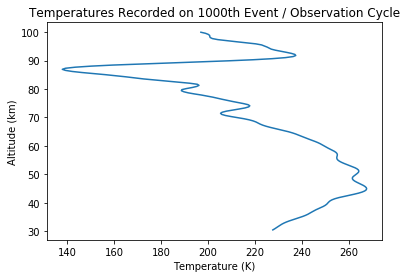

In [151]:
x = temp_event_cut(1000)
y = alt_event_cut(1000)

plt.plot(x, y)
plt.xlabel('Temperature (K)')
plt.ylabel('Altitude (km)')
plt.title('Temperatures Recorded on 1000th Event / Observation Cycle')
plt.show()

In [146]:
def plot_ctemp(lat_list, lon_list, temp_list):
    """Display a latitude vs. longitude temperature contour plot."""
    
    fig = plt.figure(figsize=(8, 4))
    left, bottom, width, height = 0, 1, 1, 1
    ax = fig.add_axes([left, bottom, width, height]) 

    x = lat_list
    y = lon_list
    X, Y = np.meshgrid(x, y)
    # len(X) == num of columns in Z, len(Y) == num of rows in Z 
    # aka, len(Y) == num of arrays within Z, a 2d array
    Z = temp_list

    cp = plt.contourf(X, Y, Z, cmap='coolwarm')
    plt.colorbar(cp).set_label('Temperature ( $K$ )', rotation=270, labelpad=15)

    
    ax.set_title('Temperature in Arctic 2009/15 31 km Altitude', size=14)
    ax.set_xlabel('Latitude ( $km$ )')
    ax.set_ylabel('Longitude( $km$ )')

    plt.show()

#### Contour Plot for 31 km

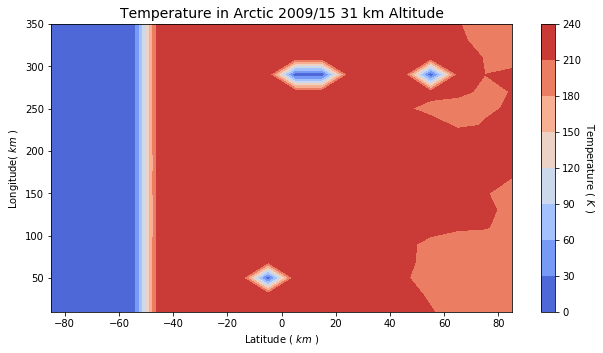

In [147]:
lat_2009015 = np.arange(-85, 95, 10) #len = 18
lon_2009015 = np.arange(10, 370, 20) #len = 18
temp_2009015 = alt_31_2009015 #len = 18 #len [i] = 18

plot_ctemp(lat_2009015, lon_2009015, temp_2009015)